In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from constants import SHARED_RANDOM_STATE
from db_helper_functions import get_stock_news_with_bertopic_sentiment_scores_from_db
from grid_model_search_functions import (
    grid_cv_test_model,
    iterative_grid_cv_model_testing,
)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ParameterGrid
from supervised_learning_data_preprocessing_functions import (
    gen_df_for_supervised_learning,
)

ticker = "AAPL"

In [3]:
bert_topic_article_sentiment_df = gen_df_for_supervised_learning(
    ticker=ticker,
    sentiment_df_retrieval_function=get_stock_news_with_bertopic_sentiment_scores_from_db,
)

dataframes_to_test = [
    (bert_topic_article_sentiment_df, "bert_topic_article_sentiment_df"),
]
cv_train_size = [126]
cv_test_size = [31]
lag_time = [5]
tss_splits = 5
features_to_use = [
    "open",
    "prev_high",
    "prev_low",
    "prev_close",
    "positive",
    "negative",
    "neutral",
]


feature_to_predict = ["closed_higher"]
scoring_method = ["accuracy"]

param_grid = {
    "data_frame": dataframes_to_test,
    "cv_train_size": cv_train_size,
    "cv_test_size": cv_test_size,
    "lag_time": lag_time,
    "feature_to_predict": feature_to_predict,
    "scoring_method": scoring_method,
}
data_settings_grid_list = list(ParameterGrid(param_grid))

/Users/raulmartinez/Desktop/MADS/Milestone_2/w24-milestone2-team18-leevw-steveso-raulmart/.venv/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [4]:
gb_clf_results = iterative_grid_cv_model_testing(
    model=GradientBoostingClassifier(),
    model_parameters={
        "random_state": [SHARED_RANDOM_STATE],
        "learning_rate": [0.1, 0.2, 0.3, 0.4],
        "n_estimators": [5, 10, 20, 100],
        "max_depth": [None, 2, 5, 10, 15, 20],
        "max_leaf_nodes": [None, 2, 5, 10, 15, 20],
    },
    data_settings_grid_list=data_settings_grid_list,
    features_to_use=features_to_use,
    tss_splits=tss_splits,
)

In [5]:
gb_clf_results = gb_clf_results.sort_values(
    ["mean_test_score", "std_test_score"], ascending=[False, True]
)

### HyperParameter Sensitivity Analysis on Best Performing Model


In [6]:
len(gb_clf_results)

576

In [7]:
gb_clf_results.tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__max_leaf_nodes,param_model__n_estimators,param_model__random_state,params,...,split4_test_score,mean_test_score,std_test_score,rank_test_score,data_frame,cv_train_size,cv_test_size,lag_time,scoring_method,features_to_use
31,0.031509,0.001951,0.001176,0.000661,0.1,2,2,100,1337,"{'model__learning_rate': 0.1, 'model__max_dept...",...,0.483871,0.464516,0.03871,571,bert_topic_article_sentiment_df,126,31,5,accuracy,"open,prev_high,prev_low,prev_close,positive,ne..."
55,0.031991,0.004213,0.000994,0.000254,0.1,5,2,100,1337,"{'model__learning_rate': 0.1, 'model__max_dept...",...,0.483871,0.464516,0.03871,571,bert_topic_article_sentiment_df,126,31,5,accuracy,"open,prev_high,prev_low,prev_close,positive,ne..."
79,0.034535,0.007666,0.002212,0.001430,0.1,10,2,100,1337,"{'model__learning_rate': 0.1, 'model__max_dept...",...,0.483871,0.464516,0.03871,571,bert_topic_article_sentiment_df,126,31,5,accuracy,"open,prev_high,prev_low,prev_close,positive,ne..."
103,0.034135,0.004138,0.001407,0.001068,0.1,15,2,100,1337,"{'model__learning_rate': 0.1, 'model__max_dept...",...,0.483871,0.464516,0.03871,571,bert_topic_article_sentiment_df,126,31,5,accuracy,"open,prev_high,prev_low,prev_close,positive,ne..."
127,0.039587,0.008825,0.001634,0.000927,0.1,20,2,100,1337,"{'model__learning_rate': 0.1, 'model__max_dept...",...,0.483871,0.464516,0.03871,571,bert_topic_article_sentiment_df,126,31,5,accuracy,"open,prev_high,prev_low,prev_close,positive,ne..."


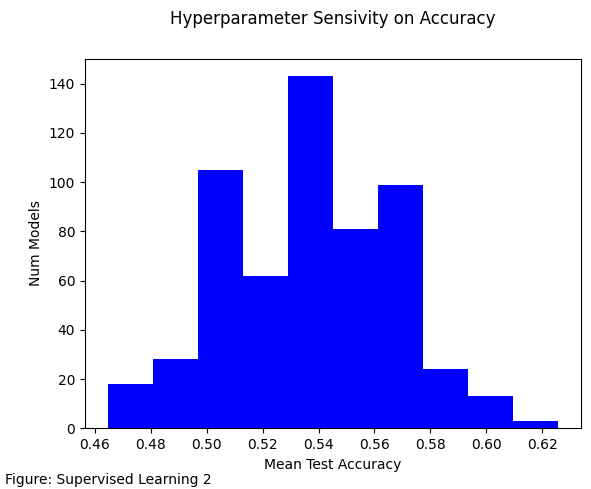

In [8]:
plt.figure()
plt.hist(
    gb_clf_results["mean_test_score"],
    color="b",
)

plt.title("Hyperparameter Sensivity on Accuracy", pad=25)
plt.xlabel("Mean Test Accuracy")
plt.ylabel("Num Models")
plt.annotate("Figure: Supervised Learning 2", xy=(5, 5), xycoords="figure pixels")
plt.show()

### Training Size Sensitivity Analysis


In [9]:
train_test_sizes = [
    (int(126 * 1), int(31 * 1)),
    (int(126 * 2), int(31 * 2)),
    (int(126 * 3), int(31 * 3)),
]

for train, test in train_test_sizes:
    gbc = GradientBoostingClassifier()
    params = {k[7:]: [v] for k, v in gb_clf_results.iloc[0].params.items()}

    best_model = grid_cv_test_model(
        model=gbc,
        model_parameters=params,
        data_frame=bert_topic_article_sentiment_df,
        features_to_use=features_to_use,
        feature_to_predict=feature_to_predict[0],
        scoring_method=scoring_method[0],
        cv_train_size=train,
        cv_test_size=test,
        lag_time=lag_time[0],
        num_tss_splits=tss_splits,
    )

    df = pd.DataFrame(best_model).sort_values("mean_test_score", ascending=False)
    print(f"TRAIN_SIZE == {train}, TEST_SIZE == {test}")
    print(round(df.iloc[0].mean_test_score, 5))
    print(round(df.iloc[0].std_test_score, 5))
    print("########")

TRAIN_SIZE == 126, TEST_SIZE == 31
0.62581
0.12675
########
TRAIN_SIZE == 252, TEST_SIZE == 62
0.52258
0.03762
########
TRAIN_SIZE == 378, TEST_SIZE == 93
0.49677
0.0375
########


### Small Training Size Testing


In [10]:
small_time_window_data_settings_grid_list = list(
    ParameterGrid(
        {
            "data_frame": dataframes_to_test,
            "cv_train_size": [21],
            "cv_test_size": [5],
            "lag_time": [5],
            "feature_to_predict": feature_to_predict,
            "scoring_method": scoring_method,
        }
    )
)

sm_gb_clf_results = iterative_grid_cv_model_testing(
    model=GradientBoostingClassifier(),
    model_parameters={
        "random_state": [SHARED_RANDOM_STATE],
        "learning_rate": [0.1, 0.2, 0.3, 0.4],
        "n_estimators": [5, 10, 20, 100],
        "max_depth": [None, 2, 5, 10, 15, 20],
        "max_leaf_nodes": [None, 2, 5, 10, 15, 20],
    },
    data_settings_grid_list=small_time_window_data_settings_grid_list,
    features_to_use=features_to_use,
    tss_splits=20,
)

In [11]:
sm_gb_clf_results = sm_gb_clf_results.sort_values(
    ["mean_test_score", "std_test_score"], ascending=[False, True]
)
sm_gb_clf_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__max_leaf_nodes,param_model__n_estimators,param_model__random_state,params,...,split19_test_score,mean_test_score,std_test_score,rank_test_score,data_frame,cv_train_size,cv_test_size,lag_time,scoring_method,features_to_use
4,0.002444,0.000560,0.000649,0.000029,0.1,None,2,5,1337,"{'model__learning_rate': 0.1, 'model__max_dept...",...,0.6,0.6,0.154919,1,bert_topic_article_sentiment_df,21,5,5,accuracy,"open,prev_high,prev_low,prev_close,positive,ne..."
28,0.002090,0.000072,0.000624,0.000008,0.1,2,2,5,1337,"{'model__learning_rate': 0.1, 'model__max_dept...",...,0.6,0.6,0.154919,1,bert_topic_article_sentiment_df,21,5,5,accuracy,"open,prev_high,prev_low,prev_close,positive,ne..."
52,0.002044,0.000024,0.000620,0.000046,0.1,5,2,5,1337,"{'model__learning_rate': 0.1, 'model__max_dept...",...,0.6,0.6,0.154919,1,bert_topic_article_sentiment_df,21,5,5,accuracy,"open,prev_high,prev_low,prev_close,positive,ne..."
76,0.002145,0.000137,0.000642,0.000043,0.1,10,2,5,1337,"{'model__learning_rate': 0.1, 'model__max_dept...",...,0.6,0.6,0.154919,1,bert_topic_article_sentiment_df,21,5,5,accuracy,"open,prev_high,prev_low,prev_close,positive,ne..."
100,0.002952,0.001850,0.000657,0.000071,0.1,15,2,5,1337,"{'model__learning_rate': 0.1, 'model__max_dept...",...,0.6,0.6,0.154919,1,bert_topic_article_sentiment_df,21,5,5,accuracy,"open,prev_high,prev_low,prev_close,positive,ne..."
